# Actividad 2: Clasificación de vestigios cerámicos.

## Contexto

En el marco de las excavaciones arqueológicas son recuperados artefactos y fragmentos de artefacto, los cuales servirán a los arqueólogos para [...]

## Indicaciones

Realice el Análisis de Conglomerados de los datos proporcionados y redacte un reporte sobre los principales hallazgos.

El reporte debe contener los siguientes elementos:

1) Definir de forma clara el objetivo del estudio que estaría realizando.

_Se quiere saber si es posible realizar una clasificación de artefactos y segmentos por periodo histórico._

2) Realizar un análisis descriptivo de la base de datos y mencionar los principales hallazgos. Aplicar alguna de las herramientas descriptivas multivariadas como las caras de Chernoff, gráficos de estrella o alguna otra, indique si existen observaciones con características similares y mencione algunos ejemplos de estas posibles relaciones.

In [1]:
library(readxl)
artefactos <- read_excel("datasets/Ceramica.xlsx", sheet="Hoja1")
artefactos <- as.data.frame(artefactos)
head(artefactos, n=5)

ID,Sitio,Al2O3,Fe2O3,MgO,CaO,Na2O,K2O,TiO2,MnO,BaO
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,15.8,7.65,1.94,0.81,0.83,3.33,0.96,0.112,0.019
2,4,15.8,2.39,0.63,0.01,0.04,1.94,1.29,0.001,0.014
3,2,13.4,6.92,7.23,0.28,0.20,4.54,0.69,0.163,0.017
4,2,11.6,5.78,5.91,0.18,0.16,3.70,0.65,0.082,0.015
5,5,16.7,0.92,0.53,0.01,0.05,1.76,0.91,0.004,0.013


_Como la concentración de elementos no es estándar, se estandariza:_

In [2]:
artefactos_st <- cbind(artefactos[,c(1:2)], scale(artefactos[,-c(1,2)], scale=TRUE))
# Vista previa
head(round(artefactos_st,3), n=5)

ID,Sitio,Al2O3,Fe2O3,MgO,CaO,Na2O,K2O,TiO2,MnO,BaO
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,0.034,0.787,-0.315,0.653,3.289,0.152,0.463,0.165,-0.055
2,4,0.034,-1.399,-1.067,-1.108,-1.138,-1.478,2.299,-0.641,-0.237
3,2,-0.854,0.484,2.722,-0.514,-0.242,1.571,-1.038,0.535,-0.128
4,2,-1.520,0.010,1.964,-0.734,-0.466,0.586,-1.261,-0.053,-0.200
5,5,0.367,-2.010,-1.124,-1.108,-1.082,-1.689,0.185,-0.619,-0.273


Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang


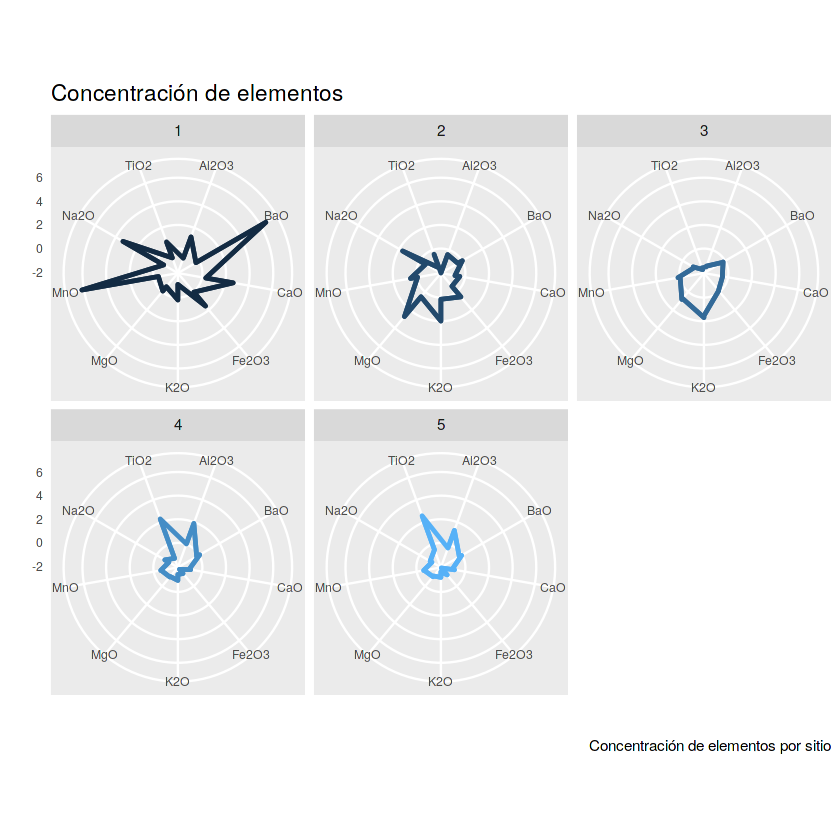

In [3]:
library(tidyr)
library(ggplot2)
suppressMessages(library(dplyr))

# Para ggplot convertimos el df wide to long
artefactos_st_long <- as.data.frame(artefactos_st) %>%
    gather(key=elemento, value=concentracion, -c(ID, Sitio))

# Si no se ordenan los datos, termina dibujando
# peces(?)
artefactos_st_long <- arrange(artefactos_st_long, elemento, concentracion)

# Funcion para que las coord polares sean lineales.
# Obtenida de:
# http://www.cmap.polytechnique.fr/~lepennec/R/Radar/RadarAndParallelPlots.html
coord_radar <- function (theta = "x", start = 0, direction = 1) 
{
    theta <- match.arg(theta, c("x", "y"))
    r <- if (theta == "x") 
        "y"
    else "x"
    ggproto("CordRadar", CoordPolar, theta = theta, r = r, start = start, 
        direction = sign(direction),
        is_linear = function(coord) TRUE)
}

ggplot(artefactos_st_long, aes(x=elemento, y=concentracion, col=Sitio, group=Sitio)) +
    geom_polygon(fill=NA, size=1) +
    geom_line(size=1) +
    coord_radar()+
    facet_wrap(~Sitio, ncol=3)+
    theme(        
        axis.text.x = element_text(size = rel(.8)),
        axis.ticks.y = element_blank(),
        axis.text.y = element_text(size = rel(.8)),
        legend.position = "none"
    )+
    labs(
        title = "Concentración de elementos",
        x="",
        y="",
        caption="Concentración de elementos por sitio"
    )

_Del gráfico anterior se obtiene que los sitios 4 y 5 tienen comportamiento similar respecto a la concentración de elementos._

3) Los estudios arqueológicos reconocen tres periodos principales. Realice un primer análisis utilizando las siguientes técnicas jerárquicas utilizando la distancia euclidiana:




  - Método del vecino más cercano

  

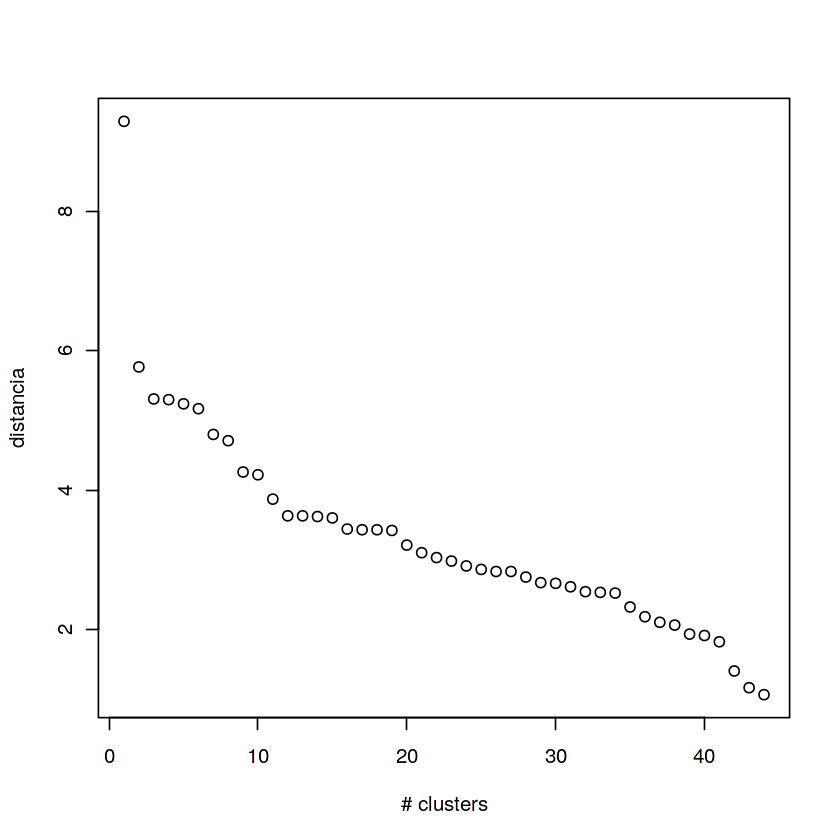

In [4]:
dist_artefactos <- round(
    proxy::dist(artefactos_st, method="euclidean", upper=T, diag=TRUE)
    ,2
)
clus_artefactos <- hclust(dist_artefactos, method="single")
plot(sort(clus_artefactos$height, decreasing=TRUE), ylab="distancia", xlab="# clusters")

_De lo anterior vemos que el punto de corte está antes de 10 clusters, pero como este no es claro, sólo graficamos los primeros 10:_

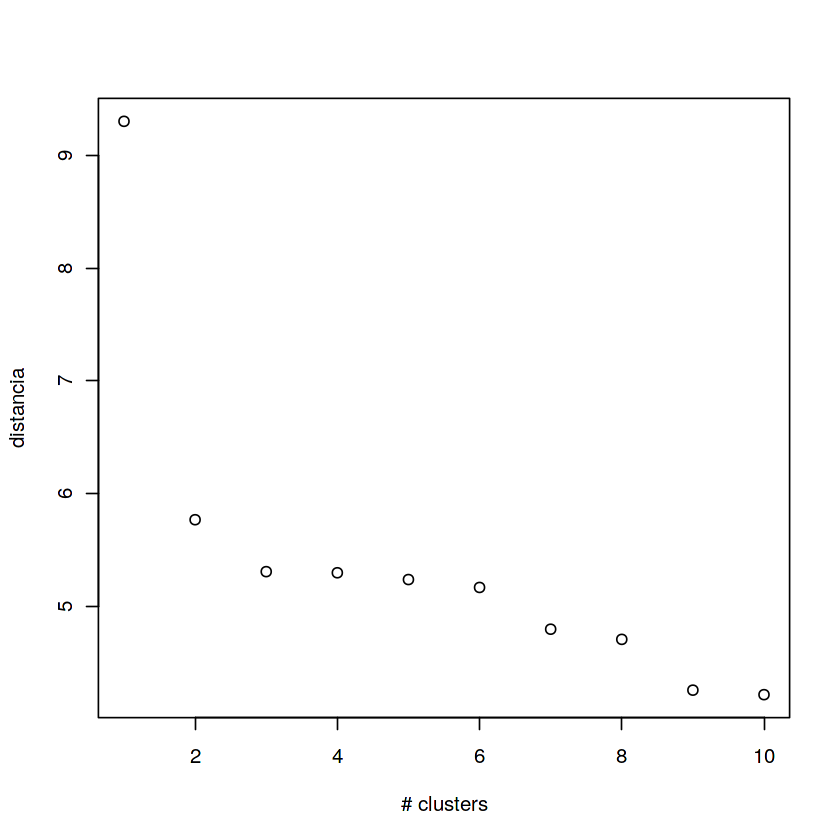

In [5]:
plot(
    head(sort(clus_artefactos$height, decreasing=TRUE),n=10),
    ylab="distancia",
    xlab="# clusters"
)

_Con este gráfico se observa que el número de clusters óptimo es 3. Habiendo obtenido el número óptimo de clusters, procedemos a hacer nuestro análisis jerárquico._ <br><br>

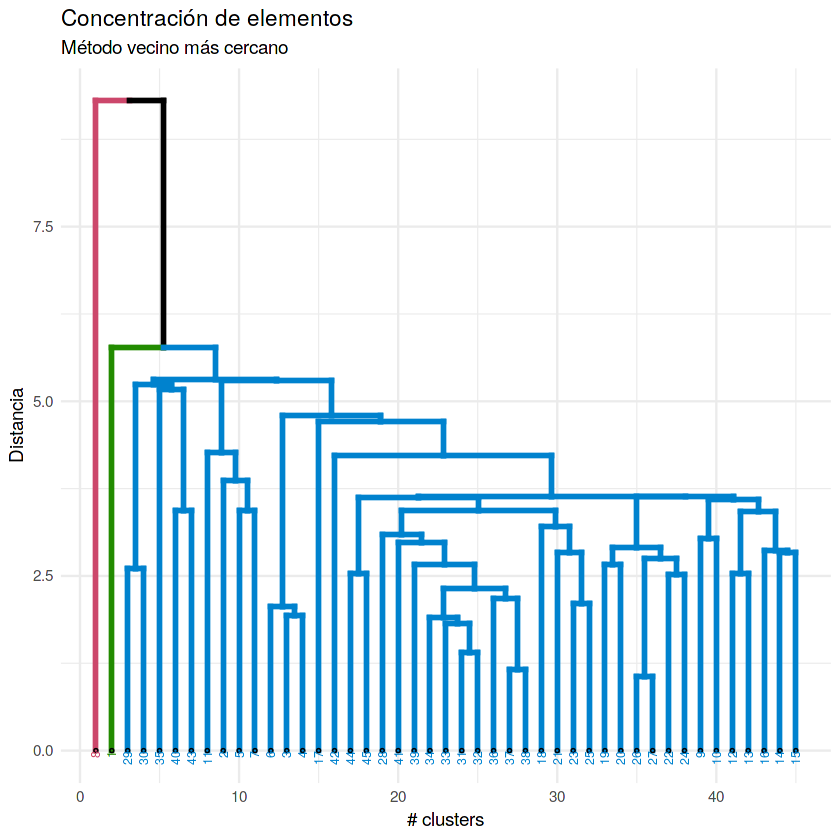

In [6]:
suppressPackageStartupMessages(library(dendextend))

num_clusters <- 3

dend <- clus_artefactos %>%
    as.dendrogram %>%
    set("branches_k_color", k=num_clusters) %>% #color de las ramas
    set("branches_lwd", 1.2) %>% # ancho de las ramas
    set("labels_cex", .5) %>% # tamaño de las hojas
    set("labels_colors", k=num_clusters) %>% # Colores de las etiquetas
    # set("leaves_pch", c(19,1,4)) %>% # tipo de punto en las hojas 
    # Parece que la opción anterior no funciona.
    set("leaves_cex", 0.5) #  color de las hojas
        
ggd1 <- as.ggdend(dend)

dendro1<-ggplot(ggd1, horiz = F, theme=theme_minimal())+
    labs(
        title = "Concentración de elementos"
        ,subtitle = "Método vecino más cercano"
        ,x = "# clusters"
        ,y = "Distancia"
    )
suppressWarnings(print(dendro1))

_En el gráfico anterior vemos que primero creó el cluster con el id 8, otro con el 1, después un cluster adicional con los demás ids._

_... pero el dendroedro no es claro mostrando los elementos del cluster 3, además de que el grupo 3 está muy desproporcionado._ 😥

  - Método de Ward
  

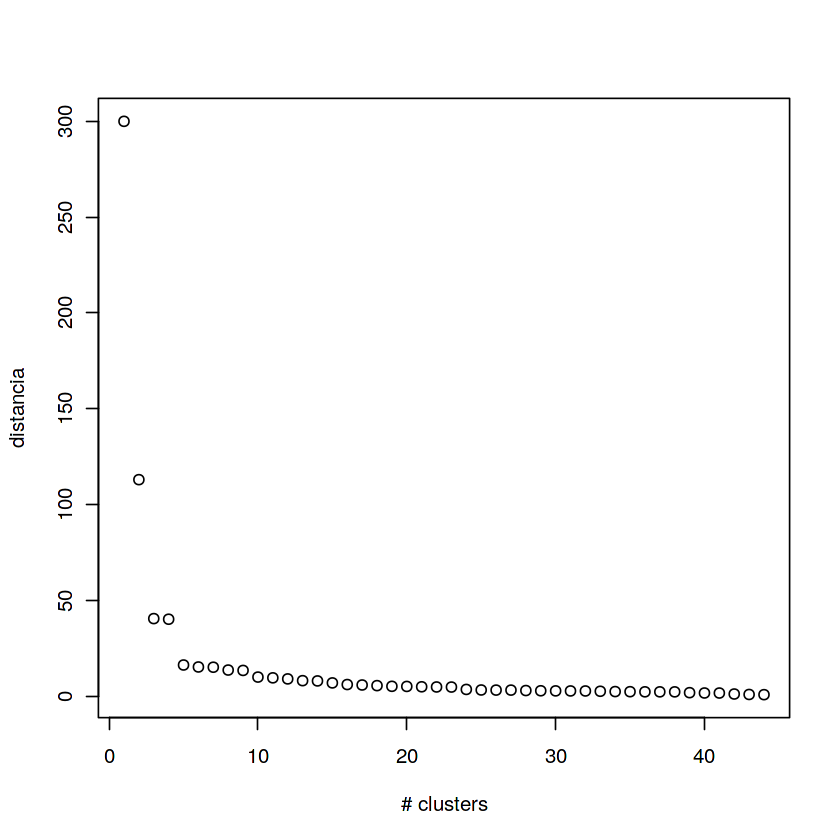

In [7]:
clus_artefactos_w <- hclust(dist_artefactos, method="ward.D")

plot(sort(clus_artefactos_w$height, decreasing=TRUE), ylab="distancia", xlab="# clusters")

Como en el caso anterior, hacemos _zoom_ en los primeros 10 clusters:

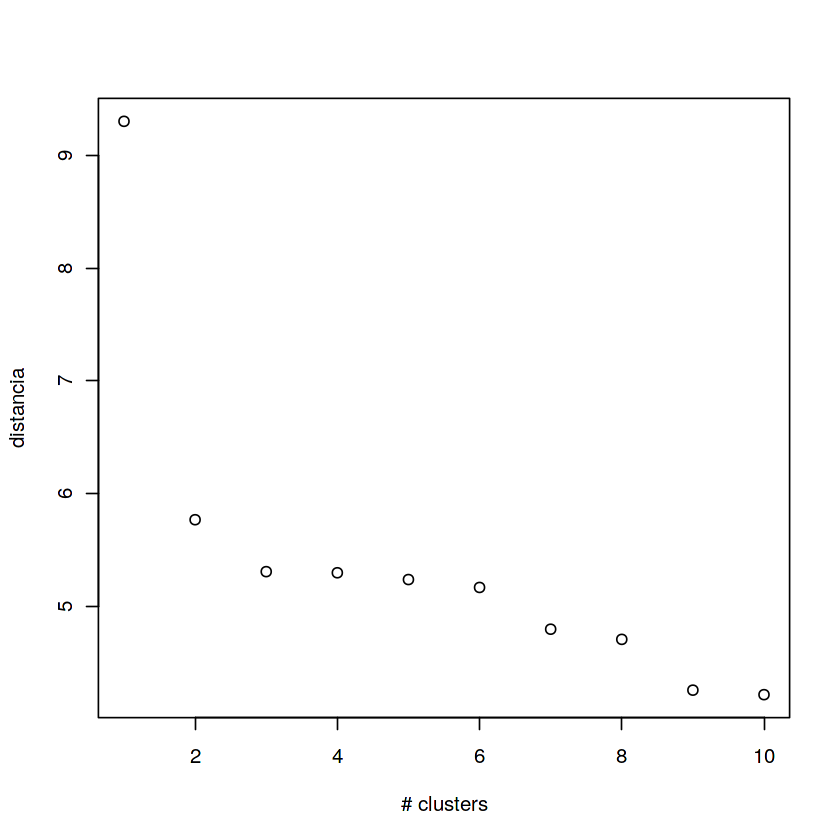

In [8]:
plot(
    head(sort(clus_artefactos$height, decreasing=TRUE),n=10),
    ylab="distancia",
    xlab="# clusters"
)

_Vemos que también el número óptimo de clústers es 3._

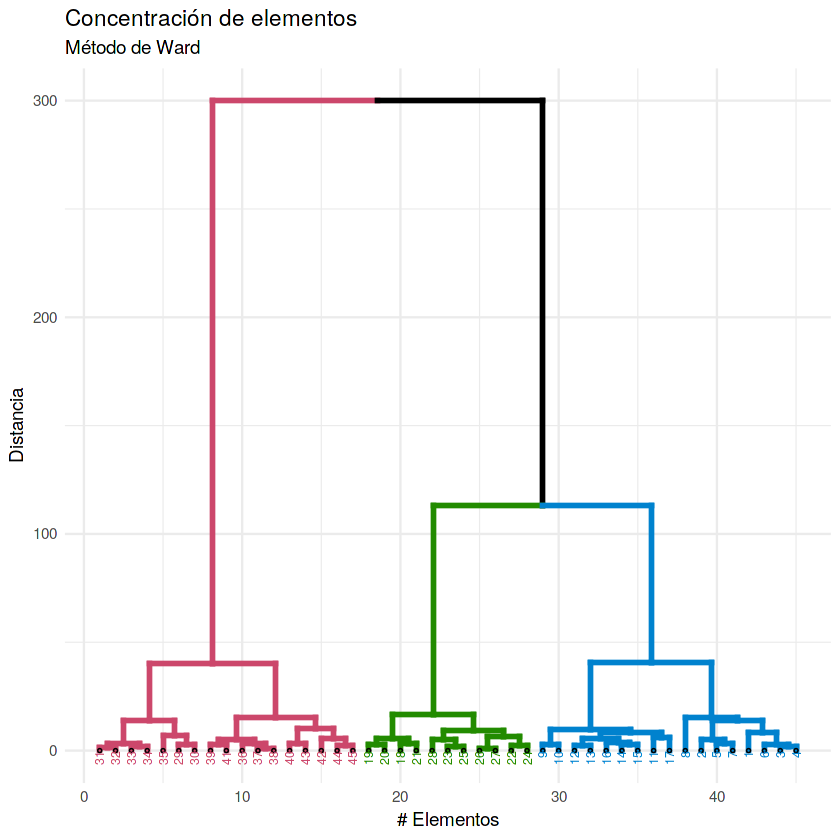

In [9]:
suppressPackageStartupMessages(library(dendextend))

num_clusters <- 3

dend <- clus_artefactos_w %>%
    as.dendrogram %>%
    set("branches_k_color", k=num_clusters) %>% #color de las ramas
    set("branches_lwd", 1.2) %>% # ancho de las ramas
    set("labels_cex", .5) %>% # tamaño de las hojas
    set("labels_colors", k=num_clusters) %>% # Colores de las etiquetas
    # set("leaves_pch", c(19,1,4)) %>% # tipo de punto en las hojas 
    # Parece que la opción anterior no funciona.
    set("leaves_cex", 0.5) #  color de las hojas    
        
ggd1 <- as.ggdend(dend)
dendro2<-ggplot(ggd1, horiz = F, theme=theme_minimal())+
    labs(
        title = "Concentración de elementos"
        ,subtitle = "Método de Ward"
        ,x = "# Elementos"
        ,y = "Distancia"
    )
suppressWarnings(print(dendro2))

_En el gráfico anterior vemos que primero creó el clúster con los id 31, 34, etc; otro con los ids 19, 20, 18, 21 y finalmente otro con 9,10, etc. También observamos que la distancia más cercana entre los elementos es en el cluster 2. Al final es claramente visible que hay una gran distancia entre el cluster 1 y los otros dos._

_Comparando ambos gráficos, se concluye que el método de Ward permite ver los grupos de manera más clara en este caso._

_Como queremos ver cuál es el orden por el cual se agrupan los datos, procedemos a graficar sus ramas:_

In [10]:
num_ramas <- 3
graficos <- list()

dend <- dend %>%
    set("nodes_pch", 19) %>%# Puntos en los nodos
    set("nodes_cex", 1) # Tamaño puntos en los nodos

for (curr_rama in 1:num_ramas) {
    # cortamos el dendrograma en distancia 50, y obtenemos la rama # curr_rama
    rama_dendro <- cut(dend, h=50)$lower[[curr_rama]]
    ggd1 <- as.ggdend(rama_dendro)
    graficos[[curr_rama]] <-ggplot(ggd1, horiz = F, theme=theme_minimal())+
    labs(
        title = paste("Rama ",curr_rama)        
        ,x = "# Elementos"
        ,y = "Distancia"
    )    
}

_Vemos cada una de las gráficas:_

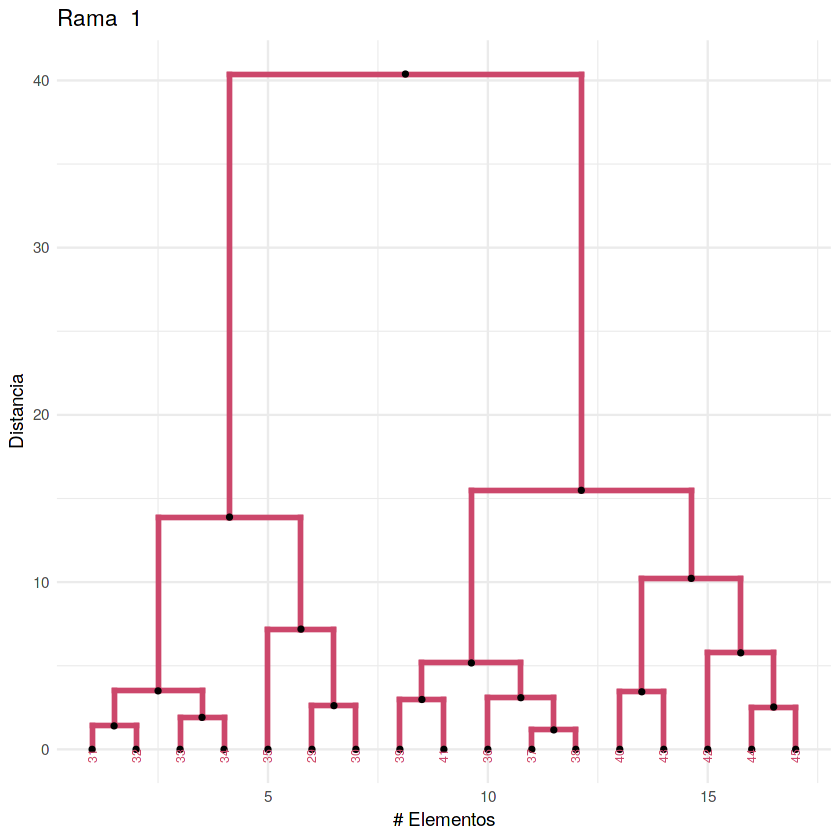

In [11]:
graficos[[1]]

_En el gráfico anterior se ve que la primera rama tiene 17 elementos, y que la menor distancia es entre los elementos 37 y 38_.

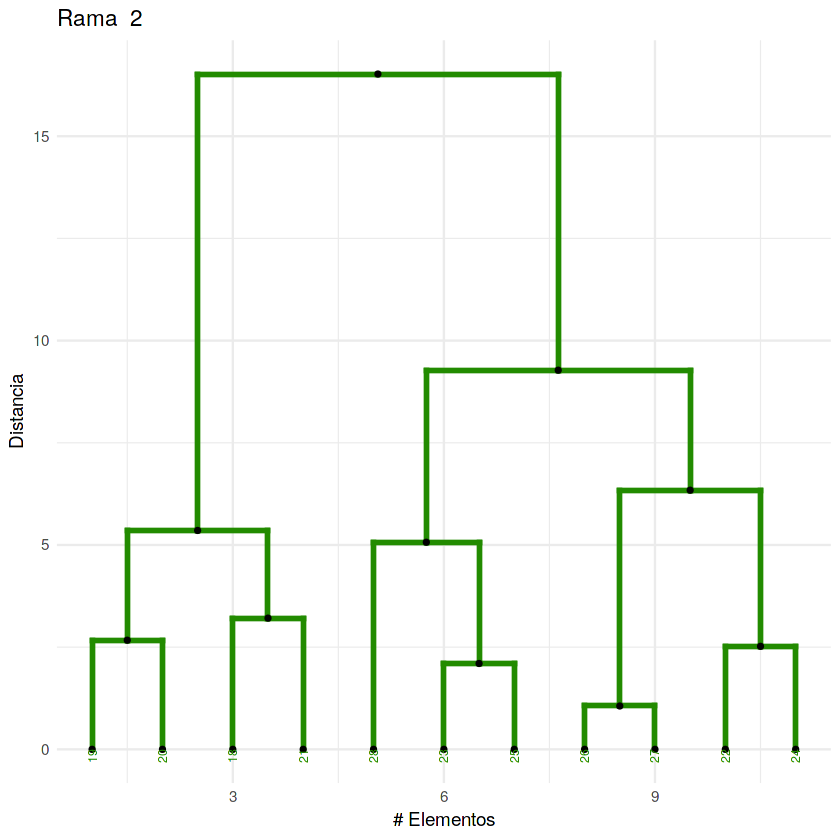

In [12]:
graficos[[2]]

_En el gráfico anterior se ve que la segunda rama tiene 11 elementos, y que la menor distancia es entre los elementos 26 y 27_.

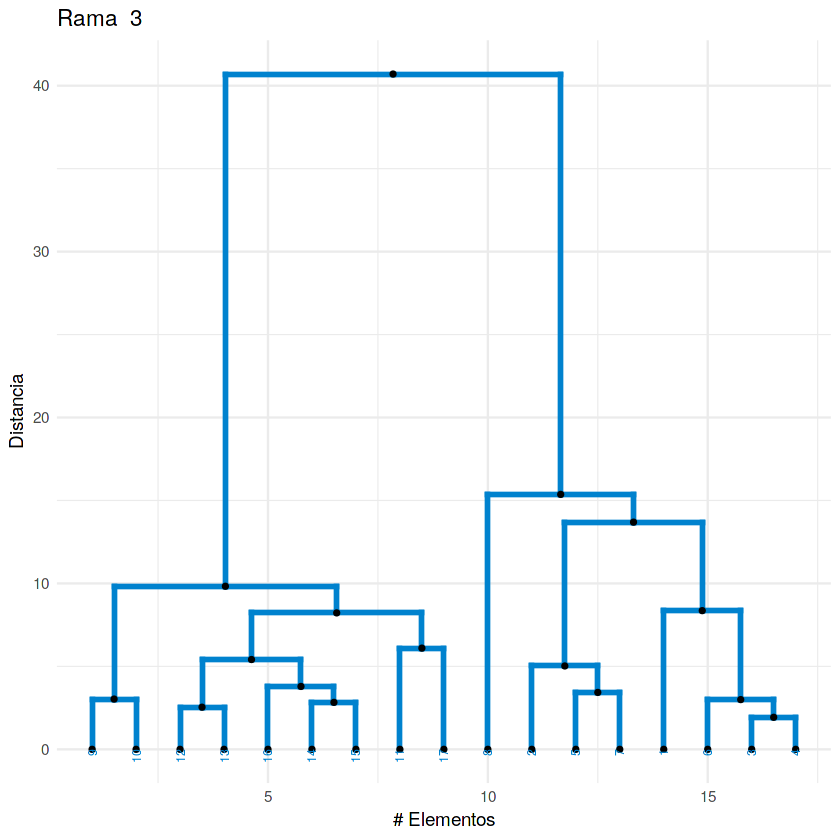

In [13]:
graficos[[3]]

_En el gráfico anterior se ve que la segunda rama tiene 17 elementos, y que la menor distancia es entre los elementos 3 y 4_.

_Revisando el árbol completo, hacemos un clusplot de los elementos para ver si se tiene algo de claridad en los grupos_

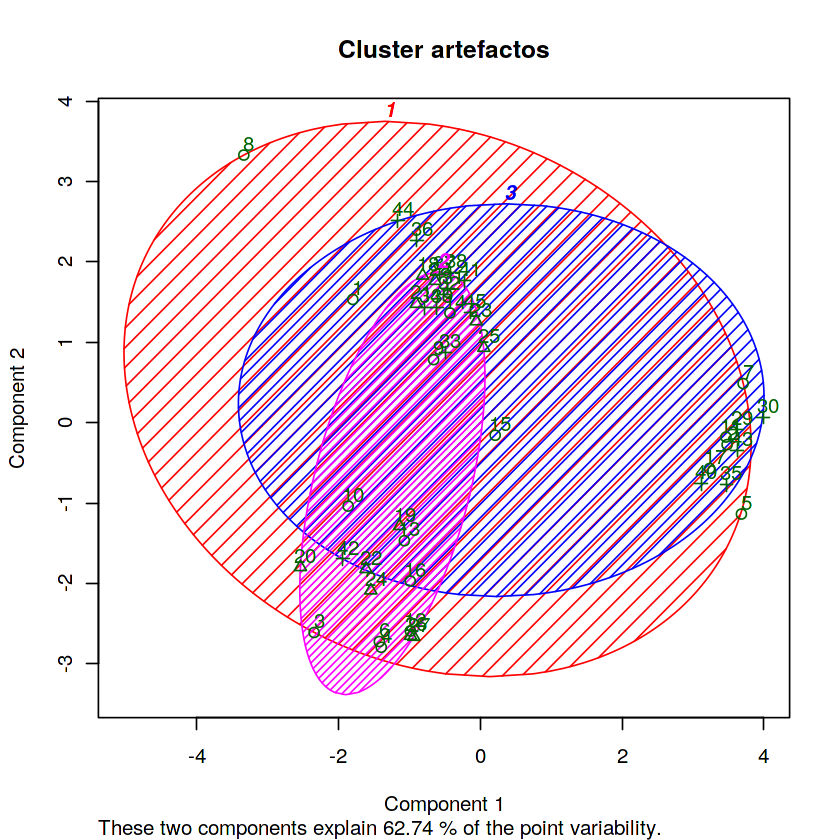

In [14]:
library(cluster)
ct_artefactos <- cutree(clus_artefactos_w, k=3)
clusplot(artefactos_st, ct_artefactos,
         color=TRUE, shade=TRUE, labels=2, lines=0,
         main="Cluster artefactos"
)

_Vemos que los elementos de los grupos coinciden con el dendrograma, pero no se ve una clara diferencia en los grupos de elementos de manera clara aunado a que hay varias intersecciones entre los grupos._

_Al menos vemos que el id 8 es un outlier._😫

Describa el procedimiento seguido, mencione como quedo la clasificación de las observaciones y la caracterización de los tres grupos a la que llegó después de este análisis. ¿Las observaciones se agruparon de la misma forma? Recuerde justificar las decisiones que toma durante el proceso de análisis.

NOTA: utilice los valores estandarizados de las variables.

**Según los comentarios del profesor: Aquí faltó hacer la caracterización de los grupos formados, es decir que características tienen los individuos que se agruparon. Similar a lo que hay al final del trabajo.**

4) Realice un segundo análisis utilizando la técnica de K-medias. Describa el procedimiento seguido y la caracterización de los tres grupos a la que llegó después de este análisis. Recuerde justificar las decisiones que toma durante el proceso de análisis. NOTA: utilice los valores estandarizados de las variables.

In [15]:
help(kmeans)

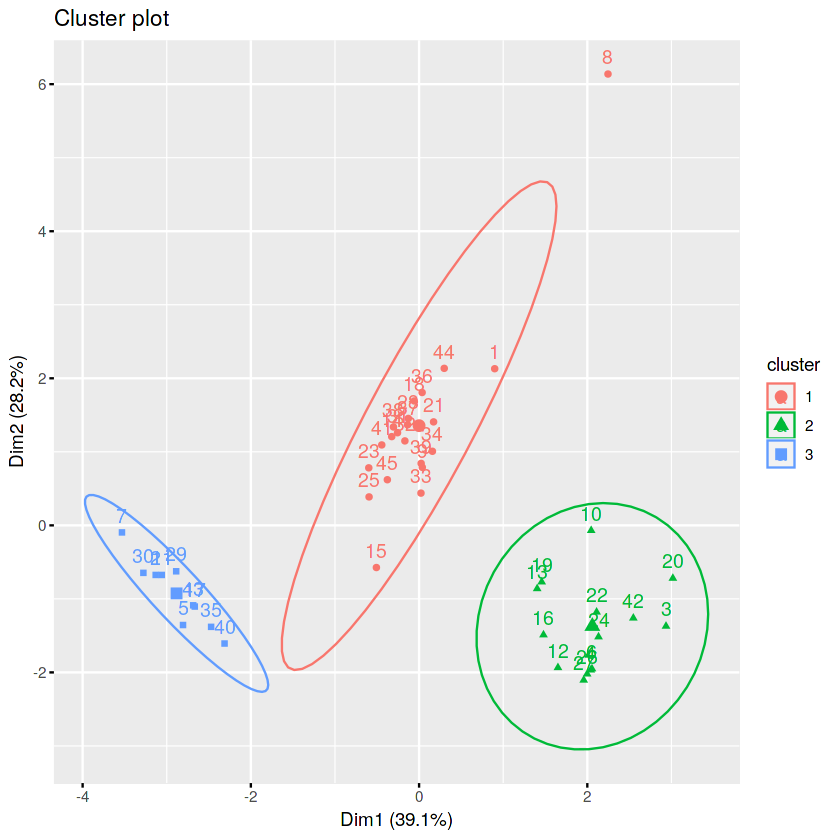

In [16]:
suppressMessages(library(factoextra))
set.seed(123)
artefactos_kmeans <- kmeans(artefactos_st[,-c(1,2)], centers=3, algorithm="Hartigan-Wong", nstart=100)

fviz_cluster(
    artefactos_kmeans,
    data = artefactos_st[,-c(1,2)],
    ellipse.type="norm",
    ellipse.alpha = 0 # hacemos transparente la elipse. 
)

_Del gráfico anterior se ven los 3 grupos claramente delimitados. Entonces procedemos a examinarlos:_

In [17]:
artefactos_st$cluster<-artefactos_kmeans$cluster

artefactos_st %>%
    filter(Sitio==4 | Sitio==5) %>%
    arrange(Sitio,ID) %>%
    select(cluster, Sitio, ID) %>%
    group_by(cluster, Sitio) %>%
    summarise(artefactos = paste(ID, collapse = " "))

cluster,Sitio,artefactos
<int>,<dbl>,<chr>
3,4,2 7 11 17 40
3,5,5 29 30 35 43


_De lo anterior vemos que como supusimos en el inciso 2, los sitios 4 y 5 son bastante similares y por tanto quedaron agrupados en el mismo cluster._

**Hizo falta mencionar las características de los grupos.**

5) Conclusiones finales: A partir de los resultados de los dos análisis anteriores, ¿qué es lo que puede comentar?, ¿cuál de los resultados es el adecuado?. De los ejemplos de observaciones similares mencionados en el inciso 2 ¿sus apreciaciones estuvieron en lo correcto? Comente algo al respecto.

_Aprovechando que tenemos los datos agrupados por cluster, aprovechamos para ver sus características:_

In [18]:
# Hacemos un list de gráficas para los clusters
artefactos_st$cluster<-artefactos_kmeans$cluster

graficos <- list()
for (curr_clust in unique(artefactos_st$cluster)) {
    artefactos_cluster <- artefactos_st[artefactos_st$cluster==curr_clust,-c(1,2)]
    pca_cluster <- prcomp(artefactos_cluster[,-c(10)], scale=F, retx=T)
    titulo_grafico<-paste("Variables Cluster", curr_clust)
    graficos[[curr_clust]] <- fviz_pca_biplot( #Esto es para crear una lista de plots
        pca_cluster,
        repel = TRUE,
        col.var = '#E34A33',
        col.ind = "cos2",        
        title = titulo_grafico,
        legend.title = "Cercania"
    )
}

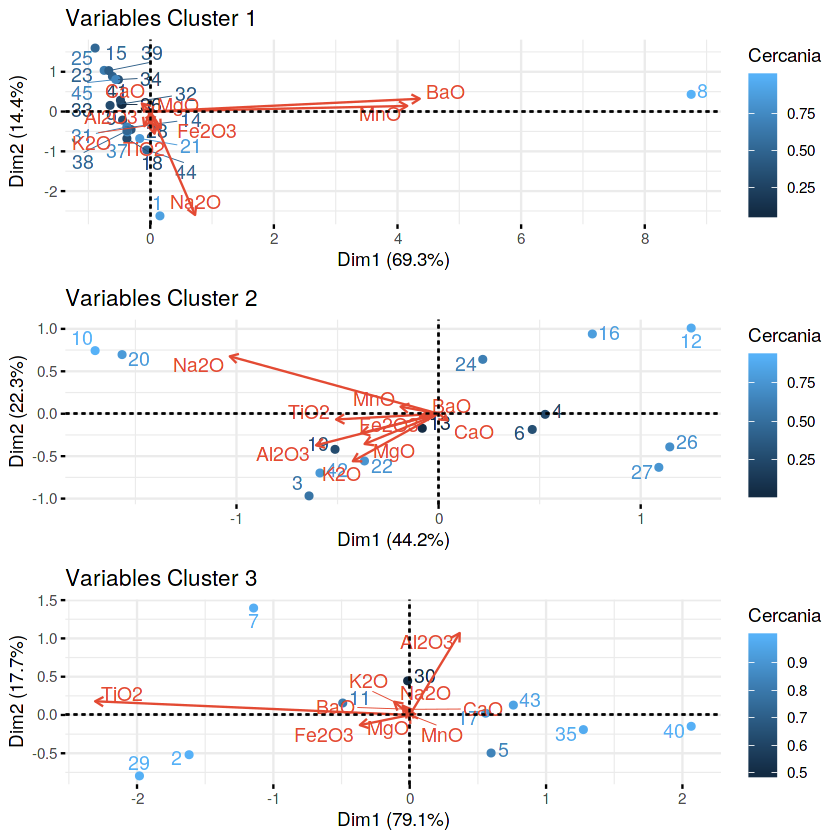

In [19]:
# Cowplot permite "agregar" gráficos en uno solo
suppressMessages(library(cowplot))
plot_grid(plotlist = graficos, ncol = 1, align = 'v')

_Llama especialmente la atención lo siguiente:_

- _En el cluster 1, los elementos 10 y 20 tienen un alto contenido de $Na_2O$ y los elementos 26 y 27 muy bajo, por lo que podría pensarse que este grupo está agrupado debido a la concentración de este elemento._
- _En el cluster 2, vemos que el agrupamiento está explicado mayormente por la concentración de_ $TiO_2$
- _En el cluster 3, el objeto ID 8 es bastante interesante ya que es muy evidente que tiene una alta concentración de MnO y BaO. Necesitaríamos revisar con el investigador para poder saber qué hacer con este elemento._

_Del ejercicio pudimos comprobar que si bien el método de Ward sirvió bastante bien para identificar el número de clusters, el método de KMedias permitió agrupar claramente los elementos. Como experiencia se obtiene que se deben comparar diferentes métodos para ver cuál de estos permite tener mejores resultados, además de que gracias a los paquetes estadísticos, se pueden hacer cuantas pruebas se necesiten._

_Como último, gracias a los gráficos de radar u otros, vemos a grosomodo cuál es el comportamiento de los diferentes elementos que queremos analizar._

**En lo que tenía dudas: El utilizar un ACP para describir las características de los grupos no es muy utilizado pero es pertinente ya que te permite visualizar las importancia de las variables en cada grupo y te da una idea más amplia que solo utilizar valores medios.**